In [ ]:
# %%
# %     COURSE: Solved problems in neural time series analysis
# %    SECTION: Time-domain analyses
# %      VIDEO: Project 2-1: Quantify the ERP as peak-mean or peak-to-peak
# % Instructor: sincxpress.com
# %
# %%

In [217]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal

In [13]:
# load sampleEEGdata.mat
eeg_data = loadmat('../data/sampleEEGdata.mat')
data = eeg_data['EEG']['data'][0][0]
times = eeg_data['EEG']['times'][0][0][0]
labels = list(np.hstack(eeg_data['EEG']['chanlocs'][0][0]['labels'][0]))
srate = eeg_data['EEG']['srate'][0][0][0][0]
data.shape

(64, 640, 99)

In [20]:
# % channel to pick
chan2use = 'o1'
indx2use = list(map(lambda x: x.lower(), labels)).index(chan2use)
indx2use

26

In [15]:
# % time window for negative peak
# % Mike's choices: 
negpeaktime = [50, 110]
pospeaktime = [110, 170]

In [16]:
# %%% compute ERP
erp = data.mean(2)

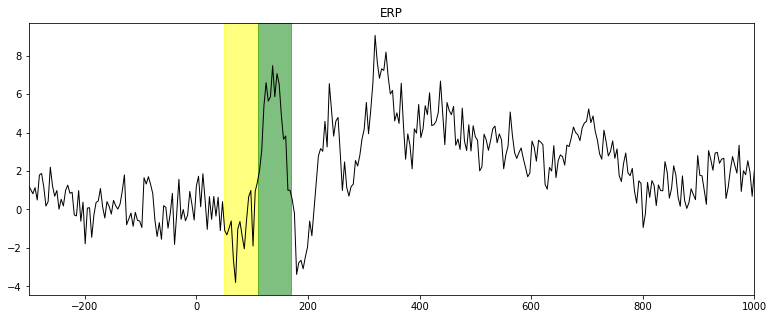

In [43]:
plt.figure(figsize=(13,5))
plt.plot(times, erp[indx2use,:], color='black', linewidth=1)
plt.title('ERP')
plt.xlim([-300, 1000])
plt.axvspan(negpeaktime[0], negpeaktime[1], alpha=0.5, color='yellow')
plt.axvspan(pospeaktime[0], pospeaktime[1], alpha=0.5, color='green')
plt.show()

In [47]:
1/srate

0.00390625

In [60]:
# %% first low-pass filter (windowed sinc function)

lowcut = 15
# filttime = np.arange(-.3, .3, 1/srate)
# filtkern = np.sin(2*np.pi*lowcut*filttime) / filttime

# # % adjust NaN and normalize filter to unit-gain
# # filtkern(~isfinite(filtkern)) = max(filtkern);
# filtkern = filtkern / np.sum(filtkern)

# # % windowed sinc filter
# # filtkern = filtkern .* hann(length(filttime))';

filtord = int(3*(lowcut*1000/srate))
filtkern = signal.firwin(filtord, lowcut/(srate/2), window="hamming", pass_zero='lowpass')

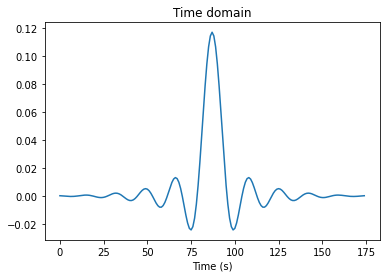

In [61]:
# % inspect the filter kernel
plt.plot(filtkern)
plt.xlabel('Time (s)')
plt.title('Time domain')
plt.show()

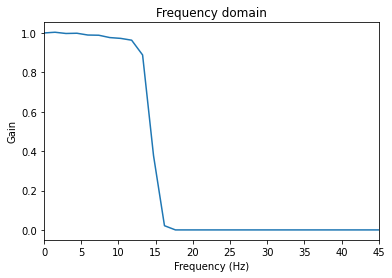

In [62]:
hz = np.linspace(0, srate, filtkern.shape[0])

plt.plot(hz, (np.fft.fft(filtkern)**2).real)
plt.xlim([0, lowcut*3])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency domain')
plt.show()

In [63]:
# %% now filter the ERP and replot

# % apply filter
erp_filtered = signal.filtfilt(filtkern,1,erp)

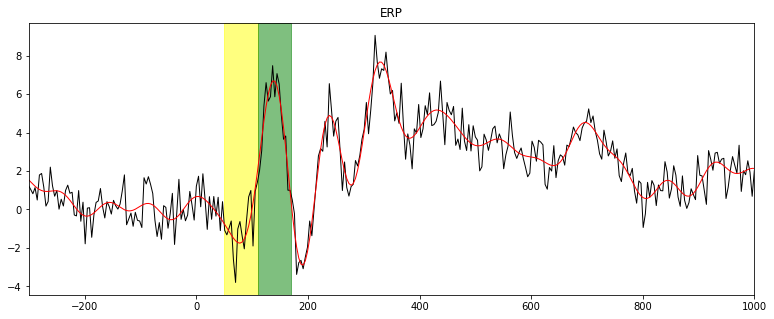

In [86]:
# % plot on top of unfiltered ERP
plt.figure(figsize=(13,5))
plt.plot(times, erp[indx2use,:], color='black', linewidth=1)
plt.plot(times, erp_filtered[indx2use,:], color='red', linewidth=1)
plt.title('ERP')
plt.xlim([-300, 1000])
plt.axvspan(negpeaktime[0], negpeaktime[1], alpha=0.5, color='yellow')
plt.axvspan(pospeaktime[0], pospeaktime[1], alpha=0.5, color='green')
plt.show()

In [ ]:
# %% peak-to-peak voltages and timings

# %%%% first for unfiltered ERP

# % find minimum/maximum peak values and peak times
# % ERP timings
# % get results (peak-to-peak voltage and latency)

In [87]:
min_pv = erp[indx2use, (times >= negpeaktime[0]) & (times <= negpeaktime[1])].min()
min_pt = times[np.where(erp[indx2use,:]==min_pv)[0][0]]
print(min_pt, min_pv)

70.3125 -3.7917705


In [88]:
max_pv = erp[indx2use, (times >= pospeaktime[0]) & (times <= pospeaktime[1])].max()
max_pt = times[np.where(erp[indx2use,:]==max_pv)[0][0]]
print(max_pt, max_pv)

136.71875 7.475273


In [90]:
# %%%% then for low-pass filtered ERP
min_pv_f = erp_filtered[indx2use, (times >= negpeaktime[0]) & (times <= negpeaktime[1])].min()
min_pt_f = times[np.where(erp_filtered[indx2use,:]==min_pv_f)[0][0]]
print(min_pt_f, min_pv_f)

78.125 -1.7485735848874133


In [93]:
max_pv_f = erp_filtered[indx2use, (times >= pospeaktime[0]) & (times <= pospeaktime[1])].max()
max_pt_f = times[np.where(erp_filtered[indx2use,:]==max_pv_f)[0][0]]
print(max_pt_f, max_pv_f)

136.71875 6.675086804331888


In [100]:
# P2P for unfiltered:
erpP2P = max_pv - min_pv
erpP2Plat = max_pt - min_pt

# P2P for filtered:
erpFP2P = max_pv_f - min_pv_f
erpFP2Plat = max_pt_f - min_pt_f

In [102]:
print('RESULTS FOR PEAK POINT:')
print(f'Peak-to-peak on unfiltered ERP: {erpP2P: .2f} muV, {erpP2Plat: .2f} ms span.')
print(f'Peak-to-peak on filtered ERP: {erpFP2P: .2f} muV, {erpFP2Plat: .2f} ms span.')

RESULTS FOR PEAK POINT:
Peak-to-peak on unfiltered ERP:  11.27 muV,  66.41 ms span.
Peak-to-peak on filtered ERP:  8.42 muV,  58.59 ms span.


In [107]:
# %% repeat for mean around the peak

# % time window for averaging (one-sided!!)
win = 10 # in ms
# % now convert to indices
win_pnts = int(round(win*10**(-3)*srate))
win_pnts

3

In [142]:
upper = np.where(times == min_pt)[0][0] + win_pnts
lower = np.where(times == min_pt)[0][0] - win_pnts

min_pv_avg = erp[indx2use, [range(lower, upper+1)]].mean()
min_pt_avg = times[range(lower, upper+1)].mean()
print(min_pt_avg, min_pv_avg)

70.3125 -1.5679191


In [137]:
upper = np.where(times == max_pt)[0][0] + win_pnts
lower = np.where(times == max_pt)[0][0] - win_pnts

max_pv_avg = erp[indx2use, [range(lower, upper+1)]].mean()
max_pt_avg = times[range(lower, upper+1)].mean()
print(max_pt_avg, max_pv_avg)

136.71875 6.4277997


In [138]:
upper = np.where(times == min_pt_f)[0][0] + win_pnts
lower = np.where(times == min_pt_f)[0][0] - win_pnts

min_pv_f_avg = erp[indx2use, [range(lower, upper+1)]].mean()
min_pt_f_avg = times[range(lower, upper+1)].mean()
print(min_pt_f_avg, min_pv_f_avg)

78.125 -1.7189091


In [139]:
upper = np.where(times == max_pt_f)[0][0] + win_pnts
lower = np.where(times == max_pt_f)[0][0] - win_pnts

max_pv_f_avg = erp[indx2use, [range(lower, upper+1)]].mean()
max_pt_f_avg = times[range(lower, upper+1)].mean()
print(max_pt_f_avg, max_pv_f_avg)

136.71875 6.4277997


In [140]:
# P2P for unfiltered:
erpP2P = max_pv_avg - min_pv_avg
erpP2Plat = max_pt_avg - min_pt_avg

# P2P for filtered:
erpFP2P = max_pv_f_avg - min_pv_f_avg
erpFP2Plat = max_pt_f_avg - min_pt_f_avg

In [141]:
print('RESULTS FOR WINDOW AROUND PEAK:')
print(f'Peak-to-peak on unfiltered ERP: {erpP2P: .2f} muV, {erpP2Plat: .2f} ms span.')
print(f'Peak-to-peak on filtered ERP: {erpFP2P: .2f} muV, {erpFP2Plat: .2f} ms span.')

RESULTS FOR WINDOW AROUND PEAK:
Peak-to-peak on unfiltered ERP:  8.00 muV,  66.41 ms span.
Peak-to-peak on filtered ERP:  8.15 muV,  58.59 ms span.


In [ ]:
# %% Loop through each channel and find the peak time of the ERP between 100 and 400 ms. 
# %   Store these peak times in a separate variable, and then make a
# %   topographical plot of the peak times. Repeat for a low-pass filtered ERP.

In [150]:
t = times[(times>=100) & (times<=400)]
lower_indx = np.where(times == t[0])[0][0]
upper_indx = np.where(times == t[-1])[0][0]
lower_indx, upper_indx

(282, 358)

In [241]:
peak_time = []
for chan in range(erp.shape[0]):
    peak_val = erp[chan, [range(lower_indx, upper_indx+1)]].max()
    indx = (np.where(erp[chan, [range(lower_indx, upper_indx+1)]].reshape(-1) == peak_val))[0][0]
    peak_time.append(times[lower_indx+indx])
    
peak_time = np.array(peak_time)

In [243]:
peak_time_filtered = []
for chan in range(erp_filtered.shape[0]):
    peak_val = erp_filtered[chan, [range(lower_indx, upper_indx+1)]].max()
    indx = (np.where(erp_filtered[chan, [range(lower_indx, upper_indx+1)]].reshape(-1) == peak_val))[0][0]
    peak_time_filtered.append(times[lower_indx+indx])
    
peak_time_filtered = np.array(peak_time_filtered)

In [218]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
info = mne.create_info(ch_names=labels, 
                       sfreq=srate,
                       ch_types='eeg')

In [251]:
peak_time = peak_time.reshape((64,1))
peak_time_filtered = peak_time_filtered.reshape((64,1))


evoked = mne.EvokedArray(peak_time, info)
evoked.set_montage(biosemi_montage)

evoked_filtered = mne.EvokedArray(peak_time_filtered, info)
evoked_filtered.set_montage(biosemi_montage);

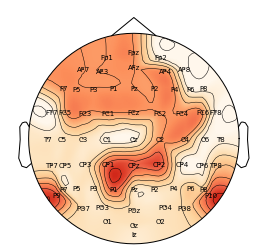

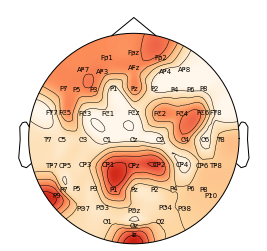

In [258]:
# plt.figure(figsize=(12,5))

mne.viz.plot_topomap(data=evoked.data[:,0], 
                     cmap='OrRd_r',
                     pos=evoked.info,
                     names=labels,
                     show_names=True)

mne.viz.plot_topomap(data=evoked_filtered.data[:,0], 
                     cmap='OrRd_r',
                     pos=evoked.info,
                     names=labels,
                     show_names=True);